# Neural Networks on Image Dataset

In this notebook, we tackle a simple image classification dataset from sklearn: the digits dataset (handwritten digits images). For this exercise, we need the `torchvision` library. To install it, simply use the following installation command,

```shell
pip install torchvision
```

## Instructions for All Labs
* Read each cell and implement the TODOs sequentially. The markdown/text cells also contain instructions which you need to follow to get the whole notebook working.
* Do not change the variable names unless the instructor allows you to.
* Some markdown cells contain questions.
  * For questions <span style="color:red;">colored in red</span>, you must submit your answers in the corresponding Assignment in the course page. Make sure that you enter your responses in the item with the matching question code. Answers that do not follow the prescribed format will automatically be marked wrong by the checker.
  * For questions <span style="color:green;">colored in green</span>, you don't have to submit your answers, but you must think about these questions as they will help enrich your understanding of the concepts covered in the labs.
* You are expected to search how to some functions work on the Internet or via the docs.
* You may add new cells for "scrap work".
* The notebooks will undergo a "Restart and Run All" command, so make sure that your code is working properly.
* You may not reproduce this notebook or share them to anyone.

In [1]:
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # pip install seaborn
import torch
import torchvision
from sklearn.datasets import load_digits

print(torchvision.__version__)

0.20.1+cu124


Set the seed for PRNG and determinism.

In [2]:
seed = 73
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define the function for plotting a given set of images.

In [3]:
plt.rcParams["savefig.bbox"] = "tight"
sns.set_style("darkgrid")


def show(images: List) -> None:
    _, axs = plt.subplots(ncols=len(images), squeeze=False)
    for index, image in enumerate(images):
        image = image.detach()
        axs[0, index].imshow(np.asarray(image), cmap="gray")
        axs[0, index].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Load the digits dataset which consists of the features $X$ and labels $y$,

In [4]:
images, labels = load_digits(return_X_y=True)

Check the shape of the images and labels.

In [5]:
images.shape, labels.shape

((1797, 64), (1797,))

Check samples of the images and labels.

In [6]:
print(images[:2])

[[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
  15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
   0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
   0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
   3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
  16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
   0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]]


In [7]:
print(labels[:2])

[0 1]


From here, we can see that there are 1,797 instances of images and labels. However, we can see that each "image" has 1x64 vectors.

Meanwhile, an image is supposed to have a width x length.

In [9]:
# to do: reshape the `images` tensor to be of `num_instances x width x length` shape
images = images.reshape(images.shape[0], 8, 8)

Retrieve the only first 5 images for plotting.

In [10]:
# to do: retrieve the first 5 images
image_grid = torchvision.utils.make_grid(torch.tensor(images[:5]))

Check that we got the first 5 items and that the images have been properly reshaped. It should have a shape of 5x8x8

In [11]:
image_grid.shape

torch.Size([5, 8, 8])

Each image having a shape of 8x8

In [12]:
image_grid[0].shape

torch.Size([8, 8])

Plot the images

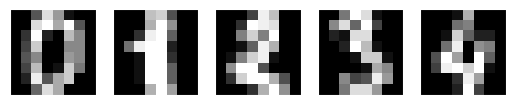

In [13]:
show(image_grid)

Confirm the labels of the images

In [14]:
# to do: print the labels
print(labels[:5])

[0 1 2 3 4]


## Dataset Preparation

We split the images and labels to training/validation/test sets. The splitting is as follows,

* Training: 80%
* Test: 20%

Then we get the 20% of the training set as the validation set, leaving us with the following,

* Training: 64%
* Validation: 16%
* Test: 20%

Recall that we reshaped our images to be of $num\_instances \times width \times length$ shape.

So, we have to reshape it back to $num\_instances \times dimensions$ before splitting them.

In [15]:
from sklearn.model_selection import train_test_split

images = images.reshape(images.shape[0], -1)

train_features, test_features, train_labels, test_labels = train_test_split(
    images, labels, test_size=2e-1, stratify=labels, shuffle=True, random_state=seed
)

train_features, validation_features, train_labels, validation_labels = train_test_split(
    train_features,
    train_labels,
    test_size=2e-1,
    stratify=train_labels,
    shuffle=True,
    random_state=seed,
)

Confirm the dataset sizes

In [16]:
# to do: print the dataset sizes
print(f"Dataset sizes:")
print(f"\tTraining: {len(train_features)}, Validation: {len(validation_features)}, Test: {len(test_features)}")

Dataset sizes:
	Training: 1149, Validation: 288, Test: 360


<span style="color:red;">**Question 6-19:** How many instances are there in the training, validation, and test sets respectively?</span>

**Answer**:

After splitting the dataset into training/validation/test sets, we can now pack them into PyTorch tensor objects.

In [17]:
train_features = torch.from_numpy(train_features).float()
train_labels = torch.from_numpy(train_labels)

# to do: pack the validation and test data into torch tensors.
validation_features = torch.from_numpy(validation_features).float()
validation_labels = torch.from_numpy(validation_labels)

test_features = torch.from_numpy(test_features).float()
test_labels = torch.from_numpy(test_labels)

For these data to be ingestible for our model, we have to pack them into a [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) objects.

In [18]:
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)

# to do: pack the validation and test features and labels into a TensorDataset
validation_dataset = torch.utils.data.TensorDataset(validation_features, validation_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

To automate the batching of the datasets during training, we pack them into [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) objects.

In [19]:
# define the batch size
batch_size = 100

import multiprocessing

# to do: pack the datasets into data loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    shuffle=True,
)

validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset,
    batch_size=len(validation_dataset),
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=len(test_dataset),
)

## Image Classifier (baseline)

Implement an image classifier neural network with the following specifications,

* 2 layers with each layer having 500 neurons each
* Each hidden layer will use logistic/sigmoid function as its activation function
* Use SGD as the optimization algorithm with learning rate $1 \times 10^{-3}$

Train for 50 epochs with mini-batch size 100. This will serve as our baseline model, which uses logistic/sigmoid function to learn the nonlinear relationships in our data.

In [20]:
class ClassifierA(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(64, 500)
        self.fc2 = torch.nn.Linear(500, 500)
        self.fc3 = torch.nn.Linear(500, 10)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        x = self.sigmoid(self.fc1(features))
        x = self.sigmoid(self.fc2(x))
        logits = self.fc3(x)
        return logits

For convenience, we define a training function for the models.

In [21]:
def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    validation_loader: torch.utils.data.DataLoader,
    epochs: int = 50,
    learning_rate: float = 1e-2,
    display_interval: int = 5
) -> Tuple[List, List, List, List]:

    # to do:
    # set the learning rate, pass the model parameters to be optimized
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    train_acc = list()
    train_loss = list()
    validation_acc = list()
    validation_loss = list()

    for epoch in range(epochs):

        epoch_loss = list()
        epoch_acc = list()

        for features_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            features_batch = features_batch.cuda()
            labels_batch = labels_batch.cuda().long()

            logits = model(features_batch)
            loss = criterion(logits, labels_batch)
            acc = (logits.argmax(dim=1) == labels_batch).float().mean()

            train_loss.append(loss.item())
            train_acc.append(acc)
            epoch_loss.append(loss.item())
            epoch_acc.append(acc.cpu().item())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                # to do: run model in inference mode
                model.eval()
                for features_batch, labels_batch in validation_loader:
                    features_batch = features_batch.cuda()
                    labels_batch = labels_batch.cuda().long()

                    logits = model(features_batch)
                    loss = criterion(logits, labels_batch)
                    acc = (logits.argmax(dim=1) == labels_batch).float().mean()

                    validation_loss.append(loss.item())
                    validation_acc.append(acc)

            # to do: enable training mode again
            model.train()

        if (epoch + 1) % display_interval == 0:
            print(f"Epoch {epoch + 1}/{epochs}")
            print(
                f"\tTraining Loss:  {np.mean(epoch_loss):.4f}, Training Acc: {np.mean(epoch_acc):.4f}"
            )
            print(f"\tValidation Loss: {loss.item():.4f}, Validation Acc: {acc.cpu().item():.4f}")
    return train_acc, train_loss, validation_acc, validation_loss

We also prepare an evaluation function.

In [22]:
def evaluate_model(
    model: torch.nn.Module, data_loader: torch.utils.data.DataLoader
) -> float:
    # to do: disable gradient computation
    model.eval()
    acc = 0.0

    with torch.no_grad():
        for features_batch, labels_batch in data_loader:
            features_batch = features_batch.cuda()
            labels_batch = labels_batch.cuda().long()

            logits = model(features_batch)
            acc += (logits.argmax(dim=1) == labels_batch).float().mean().item()

    return acc / len(data_loader)

Initialize the baseline model.

In [24]:
# initialize the model
baseline_model = ClassifierA().cuda()

# switch to GPU for computation
...

Ellipsis

<span style="color:red;">**Question 6-20:** What is the summation of the initial weight parameters for class 0 in the `baseline_model`?</span>

In [70]:
...

Ellipsis

**Answer**:

<span style="color:red;">**Question 6-21:** What is the summation of the initial weight parameters for class 9 in the `baseline_model`?</span>

In [71]:
...

Ellipsis

**Answer**:

Set the number of epochs and learning rate to be used for training

In [72]:
# to do: set the epochs and the learning rate
epochs = 50
learning_rate = 1e-2

Now, invoke the training function from earlier, to train the baseline model.

In [73]:
(
    baseline_train_acc,
    baseline_train_loss,
    baseline_validation_acc,
    baseline_validation_loss,
) = train_model(
    model=baseline_model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    epochs=epochs,
    learning_rate=learning_rate,
)

Epoch 5/50
	Training Loss:  1.6811, Training Acc: 0.8297
	Validation Loss: 1.6777, Validation Acc: 0.7882
Epoch 10/50
	Training Loss:  1.5890, Training Acc: 0.8456
	Validation Loss: 1.5835, Validation Acc: 0.8542
Epoch 15/50
	Training Loss:  1.4963, Training Acc: 0.8455
	Validation Loss: 1.4901, Validation Acc: 0.8785
Epoch 20/50
	Training Loss:  1.3957, Training Acc: 0.8624
	Validation Loss: 1.3927, Validation Acc: 0.8611
Epoch 25/50
	Training Loss:  1.3002, Training Acc: 0.8657
	Validation Loss: 1.3007, Validation Acc: 0.8681
Epoch 30/50
	Training Loss:  1.2108, Training Acc: 0.8573
	Validation Loss: 1.2117, Validation Acc: 0.8681
Epoch 35/50
	Training Loss:  1.1323, Training Acc: 0.8656
	Validation Loss: 1.1289, Validation Acc: 0.8750
Epoch 40/50
	Training Loss:  1.0565, Training Acc: 0.8831
	Validation Loss: 1.0522, Validation Acc: 0.8750
Epoch 45/50
	Training Loss:  0.9863, Training Acc: 0.8772
	Validation Loss: 0.9805, Validation Acc: 0.8924
Epoch 50/50
	Training Loss:  0.9137, T

Let's see how did the model perform.

In [74]:
baseline_test_acc = evaluate_model(model=baseline_model, data_loader=test_loader)

print(f"Baseline model test accuracy: {baseline_test_acc:.4f}")

Baseline model test accuracy: 0.8500


<span style="color:red;">**Question 6-22:** What was the validation loss at epoch 40? What is the test accuracy of the `baseline_model`?</span>

**Answer**:

## Image Classifier (challenger/experimental)

It has been more than a decade that we know the ReLU activation function significantly improves the performance of a neural network over the logistic/sigmoid function.
However, instead of simply believing the literature, we empirically explore that notion in this notebook.

Implement an image classifier neural network with the following specifications,

* 2 layers with each layer having 500 neurons each
* Each hidden layer will use ReLU function as its activation function
* Use SGD as the optimization algorithm with learning rate $1 \times 10^{-3}$

Train for 50 epochs with mini-batch size 100. This will serve as our challenger or experimental model.

Notice that the only change we introduced was the usage of ReLU activation, all other design choices remain the same. This affords us a more "apples-to-apples" comparison.

In [75]:
class ClassifierB(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(64, 500)
        self.fc2 = torch.nn.Linear(500, 500)
        self.fc3 = torch.nn.Linear(500, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.fc1(features))
        x = self.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

Initialize the experimental model.

In [76]:
# to do: initialze the experimental model
experimental_model = ClassifierB().cuda()
# to do: switch to GPU for computations

Train the experimental model.

In [77]:
(
    experimental_train_acc,
    experimental_train_loss,
    experimental_validation_acc,
    experimental_validation_loss,
) = train_model(
    model=experimental_model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    epochs=epochs,
    learning_rate=learning_rate,
)

Epoch 5/50
	Training Loss:  0.3448, Training Acc: 0.9416
	Validation Loss: 0.3081, Validation Acc: 0.9444
Epoch 10/50
	Training Loss:  0.1918, Training Acc: 0.9674
	Validation Loss: 0.2012, Validation Acc: 0.9479
Epoch 15/50
	Training Loss:  0.1395, Training Acc: 0.9733
	Validation Loss: 0.1487, Validation Acc: 0.9618
Epoch 20/50
	Training Loss:  0.1037, Training Acc: 0.9867
	Validation Loss: 0.1178, Validation Acc: 0.9792
Epoch 25/50
	Training Loss:  0.0854, Training Acc: 0.9892
	Validation Loss: 0.1089, Validation Acc: 0.9757
Epoch 30/50
	Training Loss:  0.0722, Training Acc: 0.9908
	Validation Loss: 0.1140, Validation Acc: 0.9688
Epoch 35/50
	Training Loss:  0.0612, Training Acc: 0.9908
	Validation Loss: 0.1023, Validation Acc: 0.9653
Epoch 40/50
	Training Loss:  0.0537, Training Acc: 0.9933
	Validation Loss: 0.0816, Validation Acc: 0.9792
Epoch 45/50
	Training Loss:  0.0457, Training Acc: 0.9950
	Validation Loss: 0.0834, Validation Acc: 0.9757
Epoch 50/50
	Training Loss:  0.0409, T

<span style="color:red;">**Question 6-23:** What was the training loss and validation loss at epoch 35?</span>

**Answer**:

Evaluate the trained experimental model.

In [78]:
experimental_test_acc = evaluate_model(
    model=experimental_model, data_loader=test_loader
)

print(f"Experimental model test accuracy: {experimental_test_acc:.4f}")

Experimental model test accuracy: 0.9722


<span style="color:red;">**Question 6-24:** What is the test accuracy of the experimental model?</span>

**Answer**:

## Performance Curves

Now, we define plotting functions for the training and validation losses.

In [79]:
def plot_training_values(
    training_values: List,
    validation_values: List,
    title: str,
    x_label: str,
    y_label: str,
) -> None:
    plt.plot(
        np.cumsum([v if isinstance(v, (int, float)) else v.cpu().item() for v in training_values]) / np.arange(1, len(training_values) + 1), # convert to cpu before numpy operation and check if is float/int
        label="Training",
    )
    plt.plot(
        np.cumsum([v if isinstance(v, (int, float)) else v.cpu().item() for v in validation_values]) / np.arange(1, len(validation_values) + 1), # convert to cpu before numpy operation and check if is float/int
        label="Validation",
    )
    plt.legend(loc="best")
    plt.grid(True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

Next, we define the function for plotting the loss or accuracy curves to compare the baseline model and the experimental model.

In [80]:
def plot_model_values(
    baseline_values: List,
    experimental_values: List,
    title: str,
    x_label: str,
    y_label: str,
) -> None:
    plt.plot(
        np.cumsum([v if isinstance(v, (int, float)) else v.cpu().item() for v in baseline_values]) / np.arange(1, len(baseline_values) + 1), # convert to cpu before numpy operation and check if is float/int
        label="Baseline",
    )  # cumulative moving average
    plt.plot(
        np.cumsum([v if isinstance(v, (int, float)) else v.cpu().item() for v in experimental_values]) / np.arange(1, len(experimental_values) + 1), # convert to cpu before numpy operation and check if is float/int
        label="Experimental",
    )
    plt.legend(loc="best")
    plt.grid(True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

Then, we plot the training and validation loss curves for the baseline models.

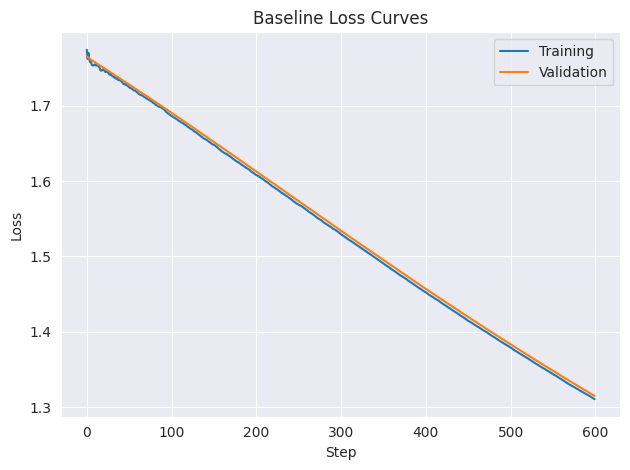

In [81]:
plot_training_values(
    training_values=baseline_train_loss,
    validation_values=baseline_validation_loss,
    title="Baseline Loss Curves",
    x_label="Step",
    y_label="Loss",
)

Then, we plot the training and validation accuracy curves for the baseline models.

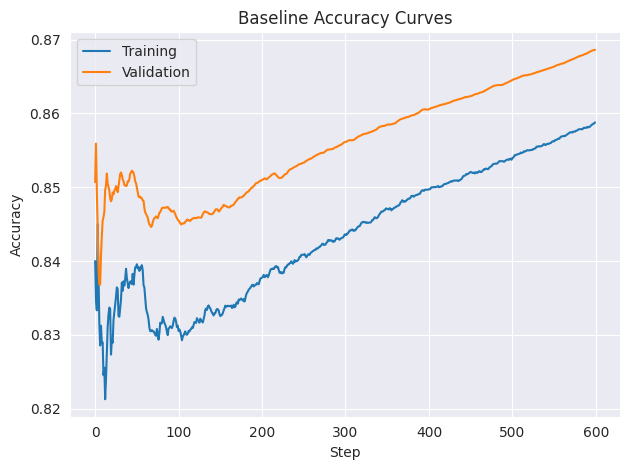

In [82]:
plot_training_values(
    training_values=baseline_train_acc,
    validation_values=baseline_validation_acc,
    title="Baseline Accuracy Curves",
    x_label="Step",
    y_label="Accuracy",
)

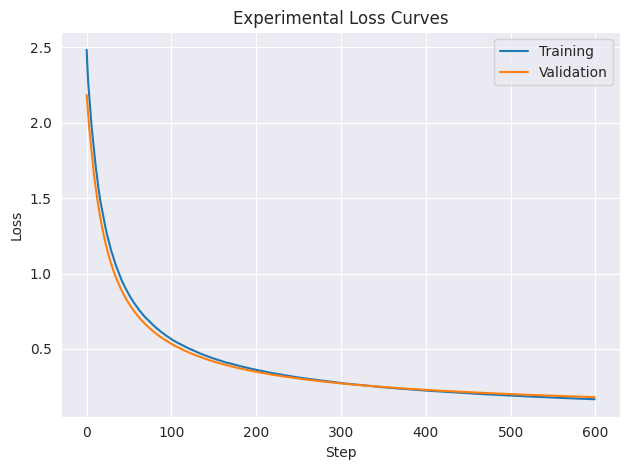

In [83]:
plot_training_values(
    training_values=experimental_train_loss,
    validation_values=experimental_validation_loss,
    title="Experimental Loss Curves",
    x_label="Step",
    y_label="Loss",
)

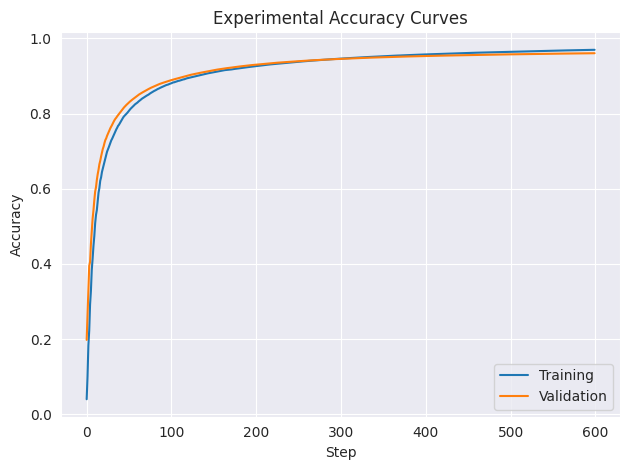

In [84]:
plot_training_values(
    training_values=experimental_train_acc,
    validation_values=experimental_validation_acc,
    title="Experimental Accuracy Curves",
    x_label="Step",
    y_label="Accuracy",
)

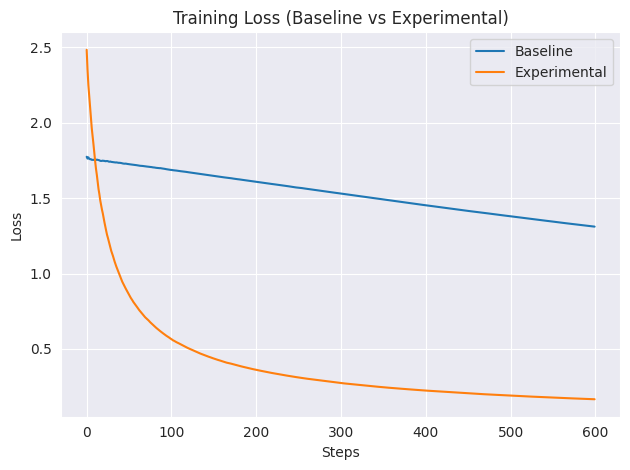

In [85]:
plot_model_values(
    baseline_train_loss,
    experimental_train_loss,
    title="Training Loss (Baseline vs Experimental)",
    x_label="Steps",
    y_label="Loss",
)

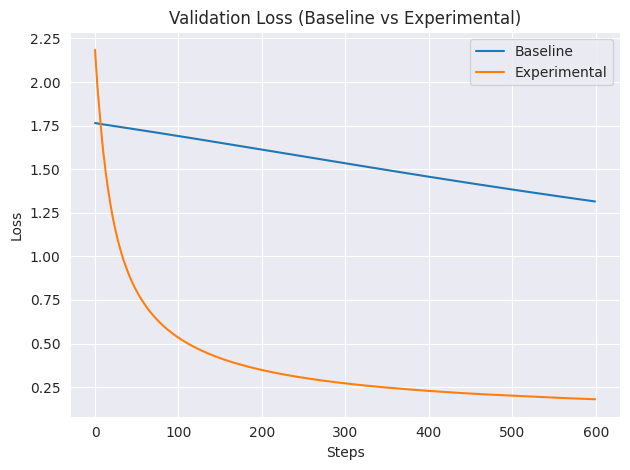

In [86]:
plot_model_values(
    baseline_validation_loss,
    experimental_validation_loss,
    title="Validation Loss (Baseline vs Experimental)",
    x_label="Steps",
    y_label="Loss",
)

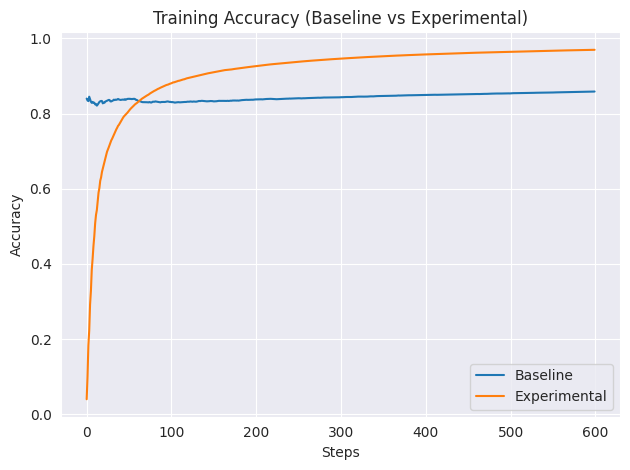

In [87]:
plot_model_values(
    baseline_train_acc,
    experimental_train_acc,
    title="Training Accuracy (Baseline vs Experimental)",
    x_label="Steps",
    y_label="Accuracy",
)

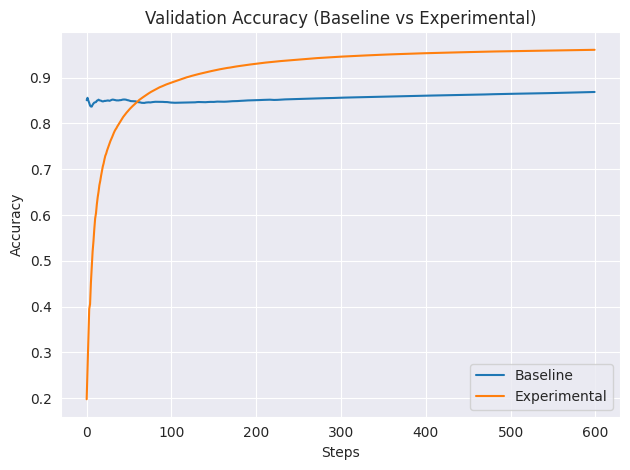

In [88]:
plot_model_values(
    baseline_validation_acc,
    experimental_validation_acc,
    title="Validation Accuracy (Baseline vs Experimental)",
    x_label="Steps",
    y_label="Accuracy",
)

## Ablation on Experimental Model

Now, let's play with our experimental model, and try to see if we could further improve its performance.

Implement an image classifier neural network with the following specifications,

* 2 layers with each layer having 500 neurons each
* Each hidden layer will use ReLU function as its activation function
* Use SGD as the optimization algorithm with the following learning rates
  * $1 \times 10^{-1}$
  * $1 \times 10^{-2}$
  * $1 \times 10^{-3}$
  * $1 \times 10^{-4}$

Train for 50 epochs with mini-batch size 100. This will serve as our challenger or experimental model.

In [89]:
# to do: define the list of learning rates
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

results = dict()

for learning_rate in learning_rates:
    # to do: initialize an experimental model for the current learning rate
    experimental_model = ClassifierB().cuda()

    # to do: switch to GPU
    experimental_model = experimental_model.cuda()

    print(f"Training model with learning rate = {learning_rate}")

    (
        experimental_train_acc,
        experimental_train_loss,
        experimental_validation_acc,
        experimental_validation_loss,
    ) = train_model(
        model=experimental_model,
        train_loader=train_loader,
        validation_loader=validation_loader,
        epochs=epochs,
        learning_rate=learning_rate,
    )

    experimental_test_acc = evaluate_model(model=experimental_model, data_loader=test_loader)
    print(f"Test accuracy: {experimental_test_acc:.4f}")

    # store the results for later retrieval
    results[f"lr-{learning_rate}"] = dict(
        train_acc=experimental_train_acc,
        train_loss=experimental_train_loss,
        validation_loss=experimental_validation_loss,
        validation_acc=experimental_validation_acc,
        test_accuracy=experimental_test_acc
    )
    print("=" * 50)

Training model with learning rate = 0.1
Epoch 5/50
	Training Loss:  0.1672, Training Acc: 0.9625
	Validation Loss: 0.1060, Validation Acc: 0.9757
Epoch 10/50
	Training Loss:  0.0215, Training Acc: 0.9975
	Validation Loss: 0.0572, Validation Acc: 0.9826
Epoch 15/50
	Training Loss:  0.0100, Training Acc: 1.0000
	Validation Loss: 0.0502, Validation Acc: 0.9757
Epoch 20/50
	Training Loss:  0.0066, Training Acc: 1.0000
	Validation Loss: 0.0541, Validation Acc: 0.9757
Epoch 25/50
	Training Loss:  0.0046, Training Acc: 1.0000
	Validation Loss: 0.0494, Validation Acc: 0.9757
Epoch 30/50
	Training Loss:  0.0035, Training Acc: 1.0000
	Validation Loss: 0.0470, Validation Acc: 0.9757
Epoch 35/50
	Training Loss:  0.0029, Training Acc: 1.0000
	Validation Loss: 0.0451, Validation Acc: 0.9792
Epoch 40/50
	Training Loss:  0.0024, Training Acc: 1.0000
	Validation Loss: 0.0465, Validation Acc: 0.9757
Epoch 45/50
	Training Loss:  0.0021, Training Acc: 1.0000
	Validation Loss: 0.0449, Validation Acc: 0.975

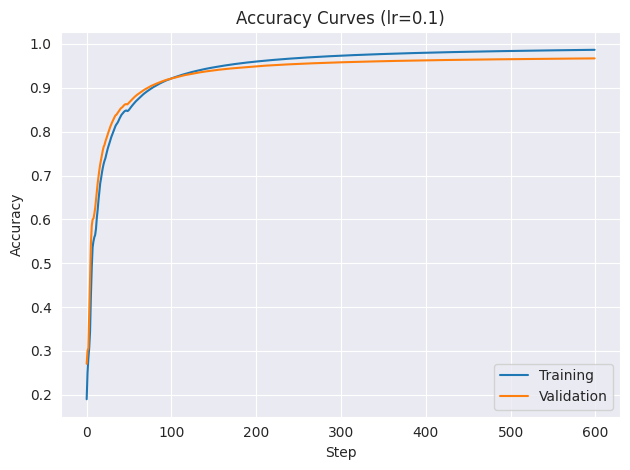

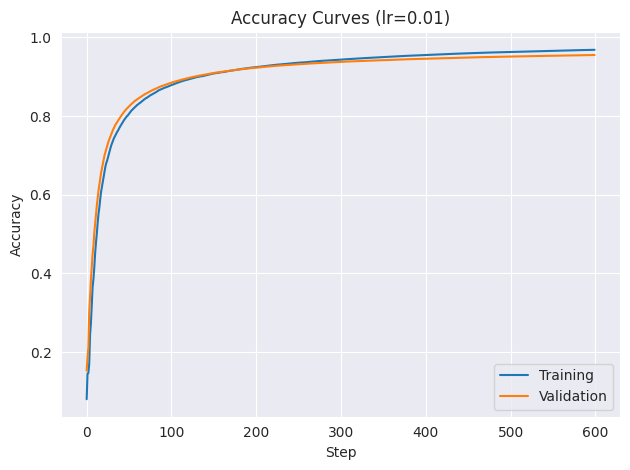

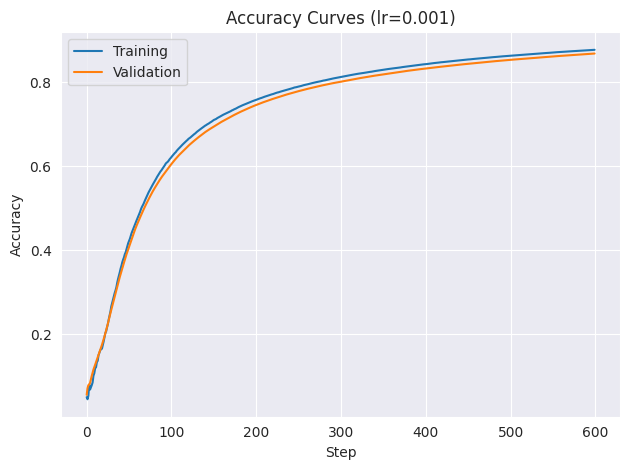

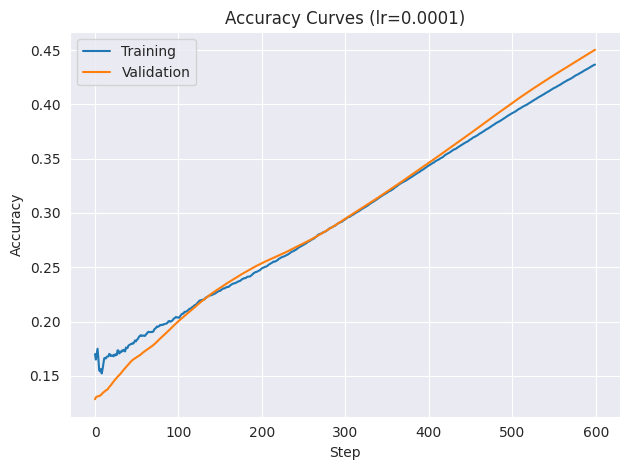

In [90]:
for learning_rate in learning_rates:
    plot_training_values(
        training_values=results[f"lr-{learning_rate}"]["train_acc"],
        validation_values=results[f"lr-{learning_rate}"]["validation_acc"],
        title=f"Accuracy Curves (lr={learning_rate})",
        x_label="Step",
        y_label="Accuracy",
    )

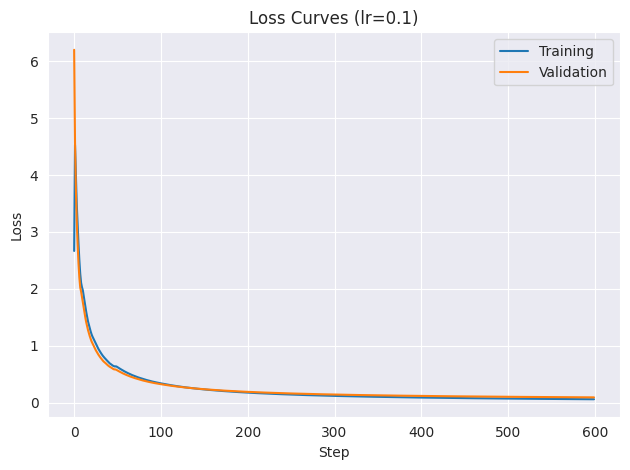

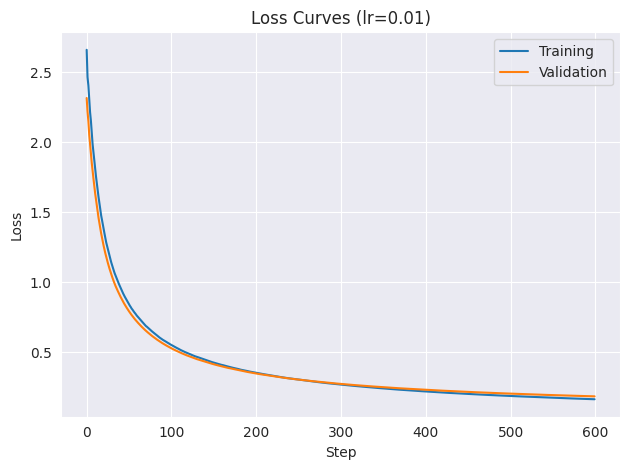

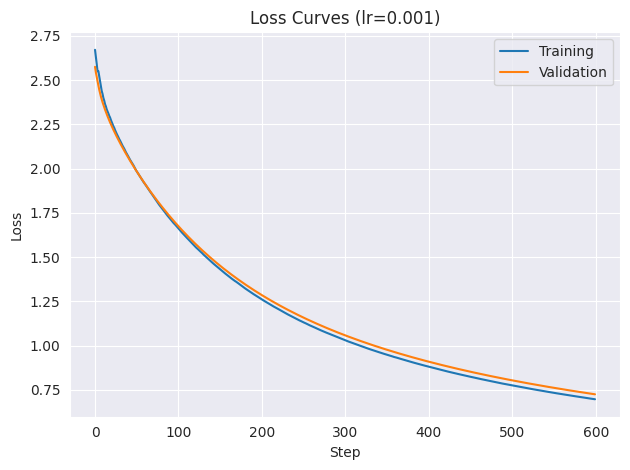

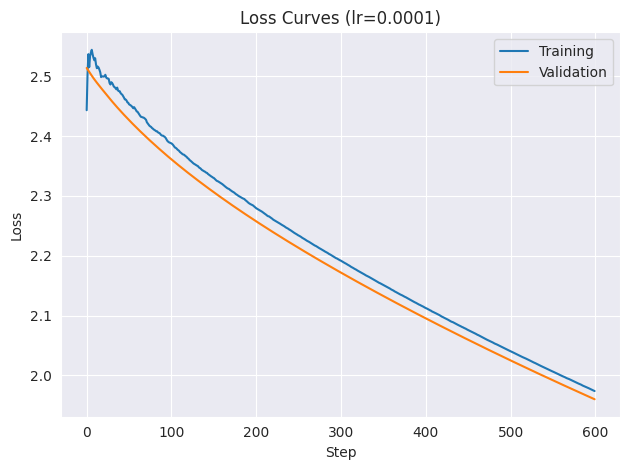

In [91]:
for learning_rate in learning_rates:
    plot_training_values(
        training_values=results[f"lr-{learning_rate}"]["train_loss"],
        validation_values=results[f"lr-{learning_rate}"]["validation_loss"],
        title=f"Loss Curves (lr={learning_rate})",
        x_label="Step",
        y_label="Loss",
    )

<span style="color:red;">**Question 6-25:** What was the best test accuracy across the 4 learning rates used for the model? What was the learning rate used?</span>

**Answer**:

<span style="color:red;">**Question 6-26:** Based on the loss curves, what can you say about the model when it was trained with a learning rate of 0.0001?</span>

**Answers**:

### <center>fin</center>


<!-- DO NOT MODIFY OR DELETE THIS -->
<sup>written by Abien Fred Agarap</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> abienfred.agarap@gmail.com</sup><br>
<!-- DO NOT MODIFY OR DELETE THIS -->